# Ted Talks Dataset Playground

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from ast import literal_eval
from statistics import mean
from collections import Counter

%matplotlib inline

First, let's have a look at the data:

In [2]:
df = pd.read_csv("../ted/ted_main.csv")
df.head()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869


In [3]:
df.shape

(2550, 17)

### Features

In this notebook we will be modeling the __views__ variable. We need to pick some predictors to regress upon. A few dataframe columns suggest themselves right away. Here is a list of low-hanging fruit, with basic intuition for selection (whether they will turn out to be informative features is a different story -- intuition is notorioulsy bad in this regard):
* __languages__: we can expect that talks subtitled in more languages will get more views (and if we had data for the actual languages, it would likely be even better).
* __duration__: in the age of short attention spans long talks might scare potential viewers.
* __published_date__: how long a talk's been available online ceritainly matters, no?
* __film_date__: on the other hand, modern audiences might not care for older material.
* __comments__: this is basically a cheat; __comments__ probably correlates with __views__, and in real world problems it is ulikely we'd have this one available at all.

Alright, let's look at some pictures to orient ourselves.

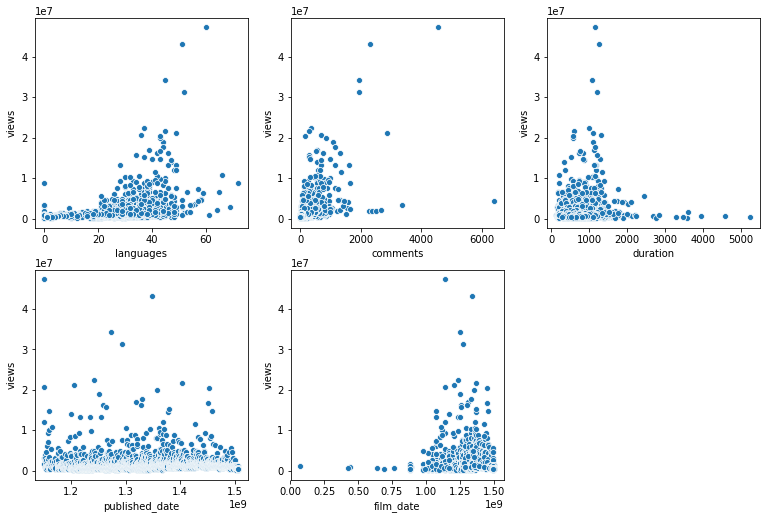

In [4]:
_, axs = plt.subplots(nrows = 2 , ncols = 3, figsize = (13, 8.5))
sns.scatterplot('languages', 'views', data = df, ax = axs[0][0])
sns.scatterplot('comments', 'views', data = df, ax = axs[0][1])
sns.scatterplot('published_date', 'views', data = df, ax = axs[1][0])
sns.scatterplot('film_date', 'views', data = df, ax = axs[1][1])
sns.scatterplot('duration', 'views', data = df, ax = axs[0][2])
axs[-1, -1].axis('off');

This doesn't look particularly good. Unsurprising, though: in the case of __views__ and __comments__ we are more interested in magnitudes, rather than raw values. Intuitively, __views__ should depend exponentially on the predictors since it is a "viral" quantity. In "stats speak": this is a count data regression problem which would usually be approached with a log-linear or a Poisson-family model.

So let's fix this.

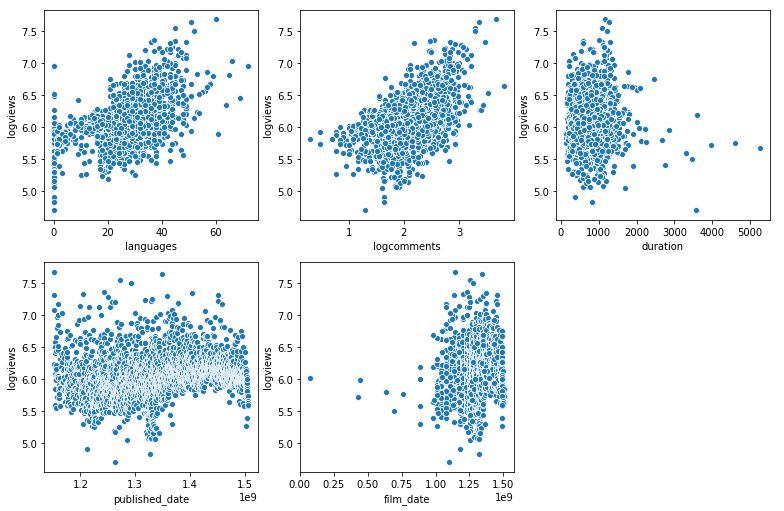

In [5]:
# using a base 10 logarithm for interpretability
df['logviews'] = np.log10(df.views)
df['logcomments'] = np.log10(df.comments)

_, axs = plt.subplots(nrows = 2 , ncols = 3, figsize = (13, 8.5))
sns.scatterplot('languages', 'logviews', data = df, ax = axs[0][0])
sns.scatterplot('logcomments', 'logviews', data = df, ax = axs[0][1])
sns.scatterplot('published_date', 'logviews', data = df, ax = axs[1][0])
sns.scatterplot('film_date', 'logviews', data = df, ax = axs[1][1])
sns.scatterplot('duration', 'logviews', data = df, ax = axs[0][2])
axs[-1, -1].axis('off');

This looks better. A few thoughts: 
1. As expected, there is a clear relationship between __languages__ and __logviews__, as well as between __logcomments__ and __logviews__. There are talks with no subtitles (languages = 0).
2. __published_date__ appears to have a non-linear relationship with __logviews__. Curiously, recently published talks actually appear to get more views than earlier talks.
3. __duration__ and __film_date__ have some outliers (or, more precisely, potential high leverage points), which we'd probably want to get rid of when using with models sensitive to outliers/high leverage.

The compressed __film_date__ plot is also masking the high correlation between __film_date__ and __published_date__:

In [6]:
df.film_date.corr(df.published_date)

0.9025645587257602

Now, let's construct some more features.

We also have __ratings__ available in our data. Using these is another cheat similar to using __comments__: it is unlikely that __ratings__ would be present in a real world problem targeting __views__. Still, let's have some fun with these too.

In [7]:
df['ratings'] = df['ratings'].apply(literal_eval) # parse back from string to dictionary 
rating_categories = set()
for row in df.itertuples():
    for cat in row.ratings:
        rating_categories.add(cat['name'])

print(len(rating_categories))
print(rating_categories)

14
{'Jaw-dropping', 'Inspiring', 'Funny', 'Courageous', 'Confusing', 'Obnoxious', 'Longwinded', 'Unconvincing', 'Beautiful', 'OK', 'Fascinating', 'Ingenious', 'Informative', 'Persuasive'}


So each talk is being rated by users in 14 qualities, which we can use as features (once again we are interested in magnitudes):

In [8]:
def scrape_ratings(list_of_dicts):
    for item in list_of_dicts:
        if item['name'] == cat:
            return np.log10(item['count']) if item['count'] > 0 else np.log10(0.1)
    return np.log10(0.1)

kwargs = {}
rating_features = []
for cat in rating_categories:
    new_coulmn = df['ratings'].apply(scrape_ratings) 
    kwargs[cat] = new_coulmn
    rating_features.append(cat)
df = df.assign(**kwargs)

Let's see how these stack together with their (log)__comments__ and (log)__views__ relatives. I present to you the correlation (c)heatmap:

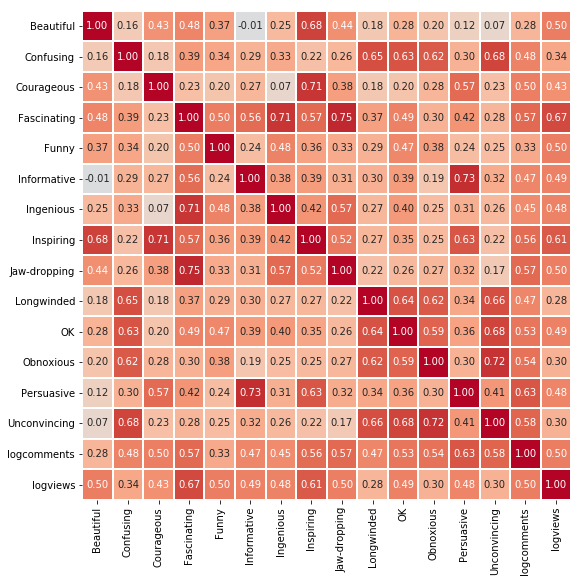

In [9]:
corr = df[sorted(rating_categories | {'logcomments', 'logviews'})].corr()

_, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(corr,  cmap = 'coolwarm', cbar = False, square = True,
            annot = True, fmt = '.2f',
            vmax = 0.8, vmin = -0.8, linewidths = 1, ax = ax);

We can see fairly strong correlations. Naturally, all the new features correlate positively with __logcomments__: perhaps users that comment are likely to leave a rating. On a side note, __unconvicing__ talks are also __confusing__, __longwinded__, __obnoxious__ and... __OK__. On the other hand, __beautiful__ is often __inspiring__, but beauty is orthogonal to being __informative__.

Next, we also have content __tags__. These sound like good candidates for features as some types of content will probably be more attractive than others.

In [10]:
df['tags'] = df['tags'].apply(literal_eval)
tags = {}
for row in df.itertuples():
    for tag in row.tags:
        tags[tag] = tags.get(tag, 0) + 1

sorted_tags = sorted(tags.items(), key = lambda kv_pair: kv_pair[1], reverse = True)

print('Tags:', len(sorted_tags))
print('Average appearances per tag:', "{0:.2f}".format(mean([tag[1] for tag in sorted_tags])))

Tags: 416
Average appearances per tag: 46.04


In [11]:
print(sorted_tags[:10])
print(sorted_tags[-10:])

[('technology', 727), ('science', 567), ('global issues', 501), ('culture', 486), ('TEDx', 450), ('design', 418), ('business', 348), ('entertainment', 299), ('health', 236), ('innovation', 229)]
[('blockchain', 3), ('epidemiology', 3), ('origami', 2), ('evil', 2), ('augmented reality', 2), ('grammar', 2), ('skateboarding', 1), ('testing', 1), ('cloud', 1), ('funny', 1)]


That's plenty of tags, and most of them are used sparingly, so they'll be quite noisy. Let's turn these into binary features. As we'll be fitting a plain linear model below (among others), we skip the exremely sparse tags. They are likely to lead to perfectly collinear features (particularly after train-test set splitting) and instability problems.

In [12]:
# we use an (arbitrary) cut-off value for excluding tag features
# a more principled feature dropping method is in order
TAG_CUTOFF_COUNT = 10
kwargs = {}
tag_features = []
for i in range(len(sorted_tags)):
    if sorted_tags[i][1] < TAG_CUTOFF_COUNT: break
    column_name = sorted_tags[i][0]
    new = df['tags'].apply(lambda x: 1 if column_name in x else 0)
    # can't have 'self' in arguments dictionary, but there is a tag 'self', so fix it
    if column_name == 'self': column_name = 'selff'
    kwargs[column_name] = new
    tag_features.append(column_name)
df = df.assign(**kwargs)
print("Tag binary features:", len(tag_features))

Tag binary features: 322


In [13]:
df.shape  # getting fat

(2550, 355)

Moving on, we also have labels for the __event__ the talk comes from. Now, this is a bit of a long shot, but it is possible that some events are more interesting than others and their talks generate more views.

In [14]:
events = Counter(df.event)
sorted_events = sorted(events.items(), key = lambda kv_pair: kv_pair[1], reverse = True)

print('Events:', len(sorted_events))
print('Average number of talks per event:', "{0:.2f}".format(mean([event[1] for event in sorted_events])))

Events: 355
Average number of talks per event: 7.18


In [15]:
print(sorted_events[:10])
print(sorted_events[-10:])

[('TED2014', 84), ('TED2009', 83), ('TED2013', 77), ('TED2016', 77), ('TED2015', 75), ('TED2011', 70), ('TEDGlobal 2012', 70), ('TED2007', 68), ('TED2010', 68), ('TEDGlobal 2011', 68)]
[('TEDxEuston', 1), ('TEDxSanQuentin', 1), ('TEDxVirginiaTech', 1), ('TEDNairobi Ideas Search', 1), ('TEDxFulbrightDublin', 1), ('TEDxOrcasIsland', 1), ('TEDxPennsylvaniaAvenue', 1), ('TEDxCrenshaw', 1), ('TEDxHamburg', 1), ('TEDxZurich', 1)]


Quite a lot of events and many of these are only represented by a single talk. We are going to encode the __event__ labels into one-hot vectors, once again dropping the sparsest labels.

In [16]:
EVENT_TALKS_CUTOFF_COUNT = 10
df_events = pd.get_dummies(df['event'], drop_first = True)
df_events = df_events.loc[:, df_events.sum(axis = 0) >= EVENT_TALKS_CUTOFF_COUNT]
df = pd.concat([df, df_events], axis = 1)
event_features = list(df_events)
print("Event features:", len(event_features))

Event features: 50


In [17]:
df.shape  # even fatter now

(2550, 405)

What else do we have? Well, there is speaker info for each of the talks. It is possible that there are speakers with multiple talks and some speakers might simply be more popular than others.

In [18]:
speakers = Counter(df.main_speaker)
sorted_speakers = sorted(speakers.items(), key = lambda kv_pair: kv_pair[1], reverse = True)

print('Speakers:', len(sorted_speakers))
print('Average number of talks per speaker:', "{0:.2f}".format(mean([speaker[1] for speaker in sorted_speakers])))

Speakers: 2156
Average number of talks per speaker: 1.18


In [19]:
print(sorted_speakers[:10])
print(sorted_speakers[-10:])

[('Hans Rosling', 9), ('Juan Enriquez', 7), ('Rives', 6), ('Marco Tempest', 6), ('Nicholas Negroponte', 5), ('Jacqueline Novogratz', 5), ('Clay Shirky', 5), ('Bill Gates', 5), ('Dan Ariely', 5), ('Julian Treasure', 5)]
[('Augie Picado', 1), ('Helen Czerski', 1), ('Sethembile Msezane', 1), ('Jun Wang', 1), ('Olúfẹ́mi Táíwò', 1), ('Duarte Geraldino', 1), ('Armando Azua-Bustos', 1), ('Radhika Nagpal', 1), ('Theo E.J. Wilson', 1), ('Karoliina Korppoo', 1)]


Encoding this information as a categorical variable would introduce too many features with questionable utility. But we can construct a reverse look-up: a feature that for each talk records the number of talks its main speaker has made. And while we are at this, let's make a similar feature for events (i.e. a measure of how major is the event the talk comes from). The information contained in this last one is already available in the event labels feature, but it may come handy nonetheless.

In [20]:
df = df.assign(speaker_talks = df['main_speaker'].apply(lambda x: np.log10(speakers[x])))
df = df.assign(event_talks = df['event'].apply(lambda x: np.log10(events[x])))

OK, that's enough for features. Additional information we could use to construct interesting features is the __related_talks__ as well as the semantic information in the talk's __description__ and __title__ to cluster or introduce a measure of similarity.

Let's organize what we have:

In [21]:
features = ['logcomments', 'languages', 'duration', 'published_date', 'film_date']
features.extend(['event_talks', 'speaker_talks'])
features.extend(rating_features)
features.extend(tag_features)
features.extend(event_features)

y = df['logviews']
X = df[features]

### Models

We'll fit a few models and then try a couple of ensembling approaches.

First, let's split the data and put aside a test set.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 997, shuffle = True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2040, 395) (510, 395) (2040,) (510,)


In [23]:
# get numpy arrays from pandas dataframes (to prevent slicing errors)
X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values

In [24]:
# also prepare a standardized version of the predictors
std_scaler = StandardScaler().fit(X_train)
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

#### Linear Regression

Let's start with a linear model (technically a log-linear model, since our response variable is logarithmic). We don't really need the standardized features here, but standardization will give us interpretable parameters.

In [25]:
lm = LinearRegression()
lm.fit(X_train_std, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [26]:
y_pred_lm = lm.predict(X_test_std)
rmse = np.sqrt(MSE(y_pred_lm, y_test))
rmse

0.16342414080853718

The $R^{2}$ statistic looks decent, but is likely inflated by the large number of predictors:

In [27]:
lm.score(X_train_std, y_train)

0.8314507426942378

Let's have a look at the residuals:

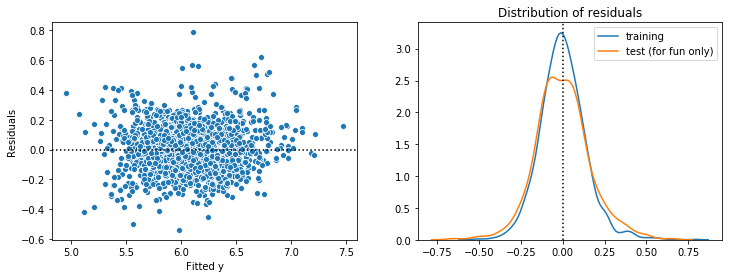

In [28]:
_, axs = plt.subplots(ncols = 2, figsize = (12, 4))

axs[0].set_xlabel('Fitted y')
axs[0].set_ylabel('Residuals')
axs[0].axhline(color = 'black', linestyle = ':')
y_train_pred = lm.predict(X_train_std)
residuals = y_train - y_train_pred
plot = sns.scatterplot(y_train_pred, residuals,  ax = axs[0]);

plot = sns.kdeplot(y_train - y_train_pred, label = 'training', ax = axs[1])
sns.kdeplot(y_test - y_pred_lm, label = 'test (for fun only)',  ax = axs[1])
plot.axvline(0, 0, 1, color = 'black', linestyle = ':')
plot.set_title("Distribution of residuals");

Not too shabby, although the slight asymmetry suggests we can probably improve a bit with a more flexible model.

And what about the model parameters:

In [29]:
print("Regression coefficients: ")
for feature, coef in zip(features, lm.coef_):
    print("{0:>7.4f}".format(coef), ':' , feature)

Regression coefficients: 
 0.0270 : logcomments
 0.1066 : languages
 0.0187 : duration
 0.1864 : published_date
-0.0075 : film_date
 0.0219 : event_talks
 0.0037 : speaker_talks
 0.0416 : Jaw-dropping
 0.0223 : Inspiring
 0.0320 : Funny
 0.0228 : Courageous
 0.0088 : Confusing
-0.0038 : Obnoxious
 0.0208 : Longwinded
-0.0086 : Unconvincing
 0.0236 : Beautiful
 0.0329 : OK
 0.0564 : Fascinating
 0.0131 : Ingenious
 0.0432 : Informative
 0.0006 : Persuasive
-0.0132 : technology
-0.0026 : science
-0.0177 : global issues
 0.0059 : culture
-0.0173 : TEDx
-0.0039 : design
 0.0046 : business
-0.0024 : entertainment
 0.0015 : health
 0.0007 : innovation
-0.0005 : society
 0.0040 : art
-0.0066 : social change
-0.0039 : future
 0.0029 : communication
-0.0003 : creativity
 0.0011 : biology
 0.0008 : humanity
-0.0029 : collaboration
-0.0009 : environment
 0.0038 : economics
-0.0037 : medicine
-0.0019 : brain
-0.0041 : activism
-0.0005 : education
 0.0011 : community
 0.0042 : history
 0.0023 : chi

Since our features are standardized, the parameters give some insight on feature importance. For example, we can see that the __ratings__ based features have detracted from __logcomments__; __published_date__ is indeed important, except that viewers actually care more for newly published material; __Fascinating__, __Informative__ and __Jaw-dropping__ talks get more views, while __Obnoxious__ and __Unconvincing__ labels suggest a tiny negative effect. Features based on __tags__, have smaller individual effects, but we can note that if you want to maximize your views you should avoid speaking at __TEDx__ on __global issues__, __technolgy__ and __Google__.

With regard to the __event__ dummy variables, note the peculiar way the coefficients tend to rise for early/mid major TED events and go down for recent major TED events. Remember the non-linear __published_date__ vs __logviews__ plot at the beginning of this notebook? By modulating the effect of __published_date__ through the parameters of the numerous __event__ based dummies the *linear* model has captured the gist of this non-linear relationship!

Of course, due to feature correlations and a high number of features we should treat superficial variable impact inference with a grain of salt.

Something else to notice is that there are parameters with extreme values. All of these correspond to some of our sparse features. Let's investigate:

In [30]:
print(np.array_equal(X_train_std[:, features.index('library')],
                     X_train_std[:, features.index('TEDNYC')]))
print(np.array_equal(X_train_std[:, features.index('TEDSalon NY2013')],
                     X_train_std[:, features.index('TEDSalon Berlin 2014')]))
print(np.array_equal(X_train_std[:, features.index('library')],
                     X_train_std[:, features.index('TEDSalon Berlin 2014')]))

True
True
True


Turns out that these 4 features are exactly the same despite our effort to prevent collinearity. Train-test splitting the data has produced this by randomizing all the differing samples into the test set. If we look closely at the parameter values, we'll notice that they sum to around 0, basically cancelling each out. With all these sparse features we should really be doing collinearity tests (for example, calculating VIF) and proper feature selection.

One thing we can easily try is switching some features off by L1-regularization.

In [31]:
# we need standardized predictors for proper regularization
# but we standardize separately on each CV iteration to
# prevent information leakage into the validation fold
lasso_params = {'lasso__alpha' : np.logspace(-3, 0, 15)}
lasso_pipe = make_pipeline(StandardScaler(), Lasso())
lasso = GridSearchCV(lasso_pipe, lasso_params, cv = 5, n_jobs = -1)
lasso.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'lasso__alpha': array([0.001  , 0.00164, 0.00268, 0.00439, 0.0072 , 0.01179, 0.01931,
       0.03162, 0.05179, 0.08483, 0.13895, 0.22758, 0.37276, 0.61054,
       1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [32]:
lasso.best_params_

{'lasso__alpha': 0.0026826957952797246}

In [33]:
y_pred_lasso = lasso.predict(X_test)
rmse = np.sqrt(MSE(y_pred_lasso, y_test))
rmse

0.16270473083877507

Looks like regularization got us a tiny improvement in prediction error, but at such a small level it might be spurious. Let's see what happened to the parameters:

In [34]:
for feature, coef in zip(features, lasso.best_estimator_.named_steps["lasso"].coef_):
    print("{0:>7.4f}".format(coef), ':' , feature)

 0.0135 : logcomments
 0.1010 : languages
 0.0140 : duration
 0.1302 : published_date
 0.0000 : film_date
 0.0129 : event_talks
 0.0003 : speaker_talks
 0.0349 : Jaw-dropping
 0.0171 : Inspiring
 0.0381 : Funny
 0.0264 : Courageous
 0.0047 : Confusing
 0.0000 : Obnoxious
 0.0151 : Longwinded
 0.0000 : Unconvincing
 0.0257 : Beautiful
 0.0284 : OK
 0.0721 : Fascinating
 0.0071 : Ingenious
 0.0351 : Informative
 0.0041 : Persuasive
-0.0060 : technology
-0.0031 : science
-0.0123 : global issues
 0.0035 : culture
-0.0085 : TEDx
-0.0000 : design
 0.0039 : business
 0.0000 : entertainment
 0.0027 : health
-0.0000 : innovation
 0.0000 : society
 0.0000 : art
-0.0028 : social change
-0.0000 : future
 0.0000 : communication
 0.0000 : creativity
-0.0000 : biology
 0.0000 : humanity
-0.0002 : collaboration
-0.0000 : environment
 0.0010 : economics
-0.0000 : medicine
-0.0000 : brain
-0.0000 : activism
 0.0000 : education
-0.0000 : community
 0.0000 : history
-0.0000 : children
-0.0083 : TED Fellow

In [35]:
print(len([c for c in lasso.best_estimator_.named_steps["lasso"].coef_ if abs(c) > 0]),
      "non-zero parameters, out of", len(features))

194 non-zero parameters, out of 393


More than half of the features were discarded and many others now have reduced magnitude, which should translate to more stable results.

In [36]:
# save the tuned hyperparameter for further use
lasso = Lasso(alpha = lasso.best_params_['lasso__alpha'])

Now that we have a baseline, let's try some non-parametric models with the purpose of building a small pool of models to test a couple of ensemble building approaches.

####  k-Nearest Neighbors

KNN doesn't like high-dimensional data, and having very sparse features won't help either:

In [37]:
# need standardized features for proper distances
# again, do it during the CV steps
# (this is a slow cell!)
knn_params = {'kneighborsregressor__n_neighbors' : [n for n in range(1, 16)],
              'kneighborsregressor__weights' : ['uniform', 'distance'],
              'kneighborsregressor__p' : [1, 2]}
knn_pipe = make_pipeline(StandardScaler(), KNeighborsRegressor())
knn = GridSearchCV(knn_pipe, knn_params, cv = 5, n_jobs = -1)
knn.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kneighborsregressor', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'kneighborsregressor__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'kneighborsregressor__weights': ['uniform', 'distance'], 'kneighborsregressor__p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [38]:
knn.best_params_

{'kneighborsregressor__n_neighbors': 14,
 'kneighborsregressor__p': 1,
 'kneighborsregressor__weights': 'distance'}

In [39]:
y_pred_knn = knn.predict(X_test)
rmse = np.sqrt(MSE(y_pred_knn, y_test))
rmse

0.24056812090353963

Ouch! That's quite bad. Let's help the model a bit by dropping the sparse features.

In [40]:
knn_features = len(features) - len(event_features) - len(tag_features)
knn_features

21

In [41]:
knn.fit(X_train[:,:knn_features], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kneighborsregressor', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'kneighborsregressor__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'kneighborsregressor__weights': ['uniform', 'distance'], 'kneighborsregressor__p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [42]:
knn.best_params_

{'kneighborsregressor__n_neighbors': 12,
 'kneighborsregressor__p': 1,
 'kneighborsregressor__weights': 'distance'}

In [43]:
y_pred_knn = knn.predict(X_test[:,:knn_features])
rmse = np.sqrt(MSE(y_pred_knn, y_test))
rmse

0.16303565545871487

We probably still have too many features for KNN's liking, but now that the error is in the vicinity of the linear model, we'll move on.

In [44]:
# save the tuned hyperparams for further use
knn = KNeighborsRegressor(n_neighbors = knn.best_params_['kneighborsregressor__n_neighbors'],
                          p = knn.best_params_['kneighborsregressor__p'],
                          weights = knn.best_params_['kneighborsregressor__weights'])

#### Random Forest & Gradient Boosting

We are also going to fit a couple of tree based models. No hyperparameter tuning in this subsection: we train with defaults to populate our library of models and move on.

In [45]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators = 100, random_state = 997)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=997, verbose=0, warm_start=False)

In [46]:
y_pred_rf = rf.predict(X_test)
rmse = np.sqrt(MSE(y_pred_rf, y_test))
rmse

0.14857404963625548

In [47]:
len([c for c in rf.feature_importances_ if abs(c) > 0])

395

In [58]:
gbt = GradientBoostingRegressor(random_state = 42)
gbt.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [59]:
y_pred_gbt = gbt.predict(X_test)
rmse = np.sqrt(MSE(y_pred_gbt, y_test))
rmse

0.1363600449085285

In [60]:
len([c for c in gbt.feature_importances_ if abs(c) > 0])

91

Note how the gradient boosting model has essentially discarded way more features than the random forest. This is likely due to the stochastic feature subsampling in each RF step, while we've trained the GB model with no feature subsampling.

### Ensembles

The goal of ensembles is to reduce model variance caused by both overfitting and model selection bias. In this notebook we implement two approaches to building ensembles. 

#### Stacking
Stacking is implemented in the manner described [here](https://mlwave.com/kaggle-ensembling-guide/) and [here](http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/).

The idea is to train a set of models (one or more) on the problem, and then train a meta-model using their predictions as features. By repeating this step we can build large hierarchical models. Improvements in generalization performance  will depend on the correlation of base model prediction errors: less correlated errors will result in a more gainful ensemble.

We need the base models to make predictions on both the training set (features for the meta-model to train on) and the test set (features for the meta-model to do predictions on). To prevent contamination, we have the base models do their training set predictions in a CV loop: predicting each fold using the out of fold data. We then retrain each base model on the full training set and generate its predictions on the test set.

Since our pool of models is very small the stacked model uses Linear Regression for a meta-model.

In [61]:
# two level stacked model

# use a subset of features for knn
models = [(lasso, -1),
          (knn, knn_features),
          (rf, -1),
          (gbt, -1)]

CV_FOLDS = 5
def oof_train_predictions(models, X_train, y_train):
    predictions = []
    for m, feat_count in models:
        cv = KFold(CV_FOLDS, shuffle = False)
        pipe = make_pipeline(StandardScaler(), m)
        pred = cross_val_predict(pipe, X_train[:, :feat_count], y_train, cv = cv, n_jobs = -1)
        predictions.append(pred)
    return np.stack(predictions, axis = -1)

def test_predictions(models, X_train, y_train, X_test):
    predictions = []
    for (m, feat_count) in models:
        m.fit(X_train[:, : feat_count], y_train)
        pred = m.predict(X_test[:, :feat_count])
        predictions.append(pred)
    return np.stack(predictions, axis = -1)
        

X_train_meta = oof_train_predictions(models, X_train, y_train)
X_test_meta = test_predictions(models, X_train_std, y_train, X_test_std)

stacked = LinearRegression()
stacked.fit(X_train_meta, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [62]:
y_pred_stacked = stacked.predict(X_test_meta)
rmse = np.sqrt(MSE(y_pred_stacked, y_test))
rmse

0.13112193984709933

In [63]:
stacked.coef_

array([0.22737748, 0.19269716, 0.07989916, 0.59107331])

To better visualize where all this modeling work has brought us, let's plot the residuals of our very first linear model versus the residuals of the linear meta-model of the stacked ensemble:

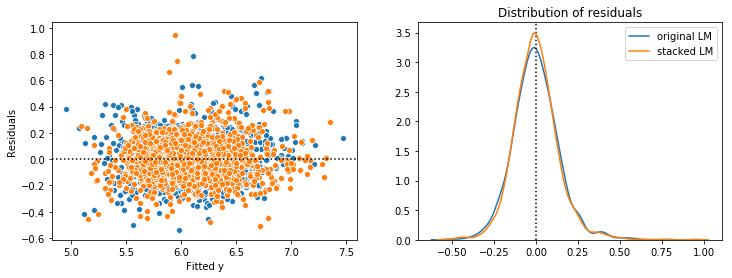

In [64]:
_, axs = plt.subplots(ncols = 2, figsize = (12, 4))
axs[0].set_xlabel('Fitted y')
axs[0].set_ylabel('Residuals')
axs[0].axhline(color = 'black', linestyle = ':')

# original linear model
y_train_pred = lm.predict(X_train_std)
residuals = y_train - y_train_pred
plot = sns.scatterplot(y_train_pred, residuals,  ax = axs[0]);
plot = sns.kdeplot(y_train - y_train_pred, label = 'original LM', ax = axs[1])
plot.axvline(0, 0, 1, color = 'black', linestyle = ':')
plot.set_title("Distribution of residuals");

# stacked model
y_train_pred = stacked.predict(X_train_meta)
residuals = y_train - y_train_pred
plot = sns.scatterplot(y_train_pred, residuals,  ax = axs[0]);
plot = sns.kdeplot(y_train - y_train_pred, label = 'stacked LM', ax = axs[1]);

#### Caruana's greedy ensemble

We also implement Caruana's greedy ensemble selection, as described in the original [paper](http://www.cs.cornell.edu/~alexn/papers/shotgun.icml04.revised.rev2.pdf).

This is a simple greedy procedure which iteratively adds models to the ensemble. On each step we see how the potential addition of a model changes the performance of the ensemble and pick the one that maximizes it. We pick with replacement, so each model can end up being picked multiple times. The end result is a weighted combination of the predictions of the base models. The paper recommends using the original set for evaluating ensemble performace during construction, so we can just reuse the out of fold base models' predictions we already have.

In [55]:
def caruana_ensemble_weights(max_iters, y_preds, y_train):
    def score_ensemble(ensemble_size, weights, y_preds):
        pred = y_preds.dot(weights) / ensemble_size
        return np.sqrt(MSE(pred, y_train))
    
    def score_candidate(current_size, weights, y_preds, candidate):
        weights[candidate] += 1
        score = score_ensemble(current_size + 1, weights, y_preds)
        weights[candidate] -= 1
        return score
    
    # start with a preinitialized ensemble as in the paper
    candidate_models = y_preds.shape[1]
    ensemble_size = candidate_models
    weights = np.ones(candidate_models) 
    ensemble_score = score_ensemble(ensemble_size, weights, y_preds)
    for _ in range(ensemble_size, max_iters):
        best_candidate = None
        for i in range(candidate_models):
            candidate_score = score_candidate(ensemble_size, weights, y_preds, i)
            if ensemble_score > candidate_score:
                ensemble_score = candidate_score
                best_candidate = i
        if best_candidate == None:
            break
        weights[best_candidate] += 1
        ensemble_size += 1
    return weights / np.sum(weights)
        
weights = caruana_ensemble_weights(50, X_train_meta, y_train)
print("Ensemble weights:", weights)

Ensemble weights: [0.16666667 0.08333333 0.08333333 0.66666667]


In [56]:
y_pred_caruana = X_test_meta.dot(weights)
rmse = np.sqrt(MSE(y_pred_caruana, y_test))
rmse

0.13445143609019156

Not a huge improvement over the best base model, but this method is usually used with big libraries of models (and chooses from a nested set of ensembles, while we stop immediately once there is no gainful pick).

Let's summarize results:

In [57]:
all_models = ['Lasso', 'kNN', 'Random Forest',
              "Gradient Boosting", "Stacked ensemble", "Caruana ensemble"]

def rmse(y_pred, y_test):
    return np.sqrt(MSE(y_pred, y_test))

mse_errors = [rmse(y_pred_lasso, y_test),
              rmse(y_pred_knn, y_test),
              rmse(y_pred_rf, y_test),
              rmse(y_pred_gbt, y_test),
              rmse(y_pred_stacked, y_test),
              rmse(y_pred_caruana, y_test)]

mae_errors = [MAE(y_pred_lasso, y_test),
              MAE(y_pred_knn, y_test),
              MAE(y_pred_rf, y_test),
              MAE(y_pred_gbt, y_test),
              MAE(y_pred_stacked, y_test),
              MAE(y_pred_caruana, y_test)]

print("{:<18}|{:>8} |{:>8} |".format("", "RMSE", "MAE"))
print("{:-<18}|{:->8} |{:->8} |".format("", "", ""))
for row, e1, e2 in zip(all_models, mse_errors, mae_errors):
    print("{:<18}|{:>8.4f} |{:>8.4f} |".format(row, e1, e2))

                  |    RMSE |     MAE |
------------------|-------- |-------- |
Lasso             |  0.1627 |  0.1217 |
kNN               |  0.1630 |  0.1195 |
Random Forest     |  0.1486 |  0.1059 |
Gradient Boosting |  0.1345 |  0.0959 |
Stacked ensemble  |  0.1305 |  0.0933 |
Caruana ensemble  |  0.1345 |  0.0955 |


So while optimizing for large errors by minimizing the mean squared error, we have achieved a mean absolute error of 0.0933. Because our target is logarithmic, this means that the predictions of our best attempt are on average off by a factor of $10^{0.0933}\approx1.24$